In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/ecoronado92/towards_data_science.git

fatal: destination path 'towards_data_science' already exists and is not an empty directory.


In [ ]:
%cd towards_data_science/hdp_example/

/content/towards_data_science/hdp_example


In [ ]:
pip install -r requirements.txt

In [ ]:
pip install gensim==3.8.3

In [ ]:
pip install tomotopy==0.7.1

In [ ]:
import pandas as pd
from pandas import option_context
import numpy as np
import re
import sys

# Tomotopy
import tomotopy as tp
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, geom_histogram, labs, theme_bw, scale_x_continuous, \
                    geom_bar, theme, lims, geom_text, position_dodge


# Gensim
import gensim.corpora as corpora
from gensim.models import Phrases, CoherenceModel
from gensim.models.phrases import Phraser
from gensim.models.wrappers import LdaMallet

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/sentisum/sentisum-assessment-dataset.csv')
#df = df.dropna(subset=['Text'])
print(df.head())

                                                text
0  Tires where delivered to the garage of my choi...
1  Easy Tyre Selection Process, Competitive Prici...
2         Very easy to use and good value for money.
3              Really easy and convenient to arrange
4  It was so easy to select tyre sizes and arrang...


In [ ]:
import pandas as pd
import spacy
import re
import nltk

from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from nltk.corpus import stopwords


def run_preprocess_e(news, min_token_len=3, rm_accent=True, bigram_min_cnt=5, bigram_thresh=100,
                   extra_stops=['from','subject','re', 'edu','use'],
                   postags=['NOUN','VERB','ADV','ADJ']):

    '''Function wrapper to preprocess the 20Newsgroup dataset and generate ready to model results
    
    *** Inputs**
    news:obj -> 20Newsgroup object from sklearn (i.e. 20fetch...)
    min_token_len: int -> tokens less than this number are excluded during tokenization
    rm_accent : bool -> flag whether to remove deaccents
    bigram_min_cnt: int -> ignore all words and bigrams with total collected count lower than this value
    bigram_thresh: int -> threshold for building phrases, higher means fewer phrases
    extra_stops: list -> extra stopwords to ignore asidr from NLTK default
    postags:list -> words/bigrams to include based on POS (part-of-speech)
    
    ** Returns**
    df: Master df with 20newgroup data and labels
    word_list_lemmatized: list -> list of lists w/ lemmatized bigrams 
    '''
    
    ### Setting up stopwords and Spacy
    nltk.download('stopwords', quiet=True)
    st_words = stopwords.words('english')
    st_words.extend(extra_stops)
    
    # Build master dataframe
    df = news['text']
    #df = pd.concat([df, pd.Series(news.target_names)],axis=1, join="inner")
    #df.reset_index(inplace=True)
    #df.columns = ["text"]

    # Convert values to list
    doc_list = df

    # Remove email signs, newlines, single quotes
    doc_list = [re.sub(r'\S*@\S*\s?', '', txt) for txt in doc_list]
    doc_list = [re.sub(r'\s+', ' ', txt) for txt in doc_list]
    doc_list = [re.sub(r"\'", "", txt) for txt in doc_list]

    # Tokenize based on min_token_len and deaccent flags
    print("Tokenizing...\n")
    word_list = [simple_preprocess(txt, deacc=rm_accent, min_len=min_token_len) for txt in doc_list]
     
    # Create bigram models
    bigram = Phrases(word_list, min_count=bigram_min_cnt, threshold=bigram_thresh) # use original wordlist to build model
    bigram_model = Phraser(bigram)
    
    # Remove stopwords
    print("Removing Stopwords...\n")
    word_list_nostops = [[word for word in txt if word not in st_words] for txt in word_list]
    
    # Implement bigram models
    print("Create bigrams...\n")
    word_bigrams = [bigram_model[w_vec] for w_vec in word_list_nostops] # implement it in the list w/ no stopwords
    
    # Lemmatize POS-tags to keep
    print("Lemmatizing, keeping " + ",".join(postags)+ " POS tags...\n")
    word_list_lemmatized = lemmatize(word_bigrams, ptags=postags)

    print("Done preprocessing " + str(df.shape[0]) + " documents")
    return df, word_list_lemmatized
    

# Helper function    
def lemmatize(word_list, ptags):
    '''Lemmatizes words based on allowed postags, input format is list of sublists 
       with strings'''
    spC = spacy.load('en_core_web_sm')
    lem_lists =[]
    for vec in word_list:
        sentence = spC(" ".join(vec))
        lem_lists.append([token.lemma_ for token in sentence if token.pos_ in ptags])
    
    return lem_lists

In [ ]:
from scripts.newsgrp_preprocess import run_preprocess

news_df, word_list_lemmatized = run_preprocess_e(df)

Tokenizing...

Removing Stopwords...

Create bigrams...

Lemmatizing, keeping NOUN,VERB,ADV,ADJ POS tags...

Done preprocessing 10132 documents


In [ ]:
word_list_lemmatized[0][:7]

['tire', 'deliver', 'garage', 'choice', 'garage', 'notify', 'deliver']

In [ ]:
news_df.head()

0    Tires where delivered to the garage of my choi...
1    Easy Tyre Selection Process, Competitive Prici...
2           Very easy to use and good value for money.
3                Really easy and convenient to arrange
4    It was so easy to select tyre sizes and arrang...
Name: text, dtype: object

In [ ]:
stop_words = set(stopwords.words('english'))
sentence = "A letter has been written asking him to be released"
for word in sentence.split():
    if word not in stop_words:
        print("Kept ==> " +word)
    else:
        print("Removed: " +word)

Kept ==> A
Kept ==> letter
Removed: has
Removed: been
Kept ==> written
Kept ==> asking
Removed: him
Removed: to
Removed: be
Kept ==> released


In [ ]:
## Example showing lemmatization
sentence = "A letter has been written asking him to be released"

spC = spacy.load('en_core_web_sm')

lemma_sentence = spC(sentence)
for token in lemma_sentence:
    print(token.text + " ==> " +token.lemma_ + ", " + token.pos_)

A ==> a, DET
letter ==> letter, NOUN
has ==> have, AUX
been ==> be, AUX
written ==> write, VERB
asking ==> ask, VERB
him ==> -PRON-, PRON
to ==> to, PART
be ==> be, AUX
released ==> release, VERB


In [ ]:
#!/usr/bin/env python3
# coding: utf-8

## Author: Eduardo Coronado (Duke University)

import gensim.corpora as corpora
from gensim.models import CoherenceModel
import sys

def train_HDPmodel_e(hdp, word_list, mcmc_iter, burn_in=100, quiet=False):
    '''Wrapper function to train tomotopy HDP Model object
    
    *** Inputs**
    hdp: obj -> initialized HDPModel model
    word_list: list -> lemmatized word list of lists
    mcmc_iter : int -> number of iterations to train the model
    burn_in: int -> MC burn in iterations
    quiet: bool -> flag whether to print iteration LL and Topics, if True nothing prints out
    
    ** Returns**
    hdp: trained HDP Model 
    '''
    
    print(word_list[:2])
    # Add docs to train
    for vec in word_list:
      hdp.add_doc(vec)

    # Initiate MCMC burn-in 
    hdp.burn_in = 100
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
    print('Removed top words:', hdp.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)

    # Train model
    step=round(mcmc_iter*0.10)
    for i in range(0, mcmc_iter, step):
        hdp.train(step, workers=3)
        if not quiet:
            print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
        
    print("Done\n")  
    
    return hdp
    
        
def get_hdp_topics(hdp, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics



def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    word_list: list -> lemmatized word list of lists
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    score: float -> coherence value
    '''
    
    # Build gensim objects
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
            
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    print("Evaluating topic coherence...")
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list, 
                    coherence=coherence_type)
    
    score = cm.get_coherence()
    print ("Done\n")
    return score

In [ ]:
from scripts.model_funcs import train_HDPmodel, get_hdp_topics


tw_list = [tp.TermWeight.ONE, # all terms weighted equally
           tp.TermWeight.PMI, # Pointwise Mutual Information term weighting
           tp.TermWeight.IDF] # down-weights high frequency terms, upweights low freq ones

tw_names = ['one', 'pmi', 'idf']
model_topics =[]

for i, term_weight in enumerate(tw_list):
    hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=7, gamma=1, alpha=0.1,
                     initial_k=10, seed=99999)
    
    print("Model " + tw_names[i] )
    hdp = train_HDPmodel_e(hdp, word_list_lemmatized, mcmc_iter=1000)
    hdp.save(''.join(['models/hdp_model_',tw_names[i],".bin"]))
    
    model_topics.append(get_hdp_topics(hdp, top_n=10))

Training...


Model one
[['tire', 'deliver', 'garage', 'choice', 'garage', 'notify', 'deliver', 'day', 'time', 'arrange', 'garage', 'go', 'fit', 'free', 'experience'], ['selection', 'process', 'competitive', 'pricing', 'excellent', 'fitting', 'service']]
Num docs: 10020 , Vocab size: 1304 , Num words: 81394
Removed top words: ['tyre', 'service', 'good', 'price', 'easy', 'fit', 'great']
Iteration: 0	Log-likelihood: -6.0829437390516015	Num. of topics: 18
Iteration: 100	Log-likelihood: -6.058076139470654	Num. of topics: 21
Iteration: 200	Log-likelihood: -6.0566673383155525	Num. of topics: 19
Iteration: 300	Log-likelihood: -6.053233944932673	Num. of topics: 22
Iteration: 400	Log-likelihood: -6.052914449169443	Num. of topics: 23
Iteration: 500	Log-likelihood: -6.05235498868439	Num. of topics: 19
Iteration: 600	Log-likelihood: -6.050824032602961	Num. of topics: 19
Iteration: 700	Log-likelihood: -6.052568081909515	Num. of topics: 18
Iteration: 800	Log-likelihood: -6.052011553067181	Num. of topics: 20
Itera

Training...


Model pmi
[['tire', 'deliver', 'garage', 'choice', 'garage', 'notify', 'deliver', 'day', 'time', 'arrange', 'garage', 'go', 'fit', 'free', 'experience'], ['selection', 'process', 'competitive', 'pricing', 'excellent', 'fitting', 'service']]
Num docs: 10020 , Vocab size: 1304 , Num words: 81394
Removed top words: ['tyre', 'service', 'good', 'price', 'easy', 'fit', 'great']
Iteration: 0	Log-likelihood: -21.517162439850907	Num. of topics: 16
Iteration: 100	Log-likelihood: -21.602644159598146	Num. of topics: 16
Iteration: 200	Log-likelihood: -21.602147243643376	Num. of topics: 16
Iteration: 300	Log-likelihood: -21.758464003852872	Num. of topics: 15
Iteration: 400	Log-likelihood: -21.74689335259187	Num. of topics: 19
Iteration: 500	Log-likelihood: -21.674155230224635	Num. of topics: 21
Iteration: 600	Log-likelihood: -22.01340419108348	Num. of topics: 24
Iteration: 700	Log-likelihood: -21.833248779701865	Num. of topics: 18
Iteration: 800	Log-likelihood: -21.663014995498404	Num. of topics: 22

Training...


Iteration: 900	Log-likelihood: -21.822177553684977	Num. of topics: 18
Done

Model idf
[['tire', 'deliver', 'garage', 'choice', 'garage', 'notify', 'deliver', 'day', 'time', 'arrange', 'garage', 'go', 'fit', 'free', 'experience'], ['selection', 'process', 'competitive', 'pricing', 'excellent', 'fitting', 'service']]
Num docs: 10020 , Vocab size: 1304 , Num words: 81394
Removed top words: ['tyre', 'service', 'good', 'price', 'easy', 'fit', 'great']
Iteration: 0	Log-likelihood: -24.45164943098501	Num. of topics: 16
Iteration: 100	Log-likelihood: -24.522872331759082	Num. of topics: 14
Iteration: 200	Log-likelihood: -24.56731880873826	Num. of topics: 15
Iteration: 300	Log-likelihood: -24.73048954680052	Num. of topics: 15
Iteration: 400	Log-likelihood: -24.737176597345147	Num. of topics: 14
Iteration: 500	Log-likelihood: -24.728258970138807	Num. of topics: 12
Iteration: 600	Log-likelihood: -24.559927371053934	Num. of topics: 13
Iteration: 700	Log-likelihood: -24.73864986332749	Num. of topics

In [ ]:
from scripts.model_funcs import get_hdp_topics

topics = get_hdp_topics(hdp, top_n=10) # changing top_n changes no. of words displayed


In [ ]:
topics

{1: [('go', 0.2246938794851303),
  ('smoothly', 0.18278135359287262),
  ('plan', 0.13751451671123505),
  ('arrive', 0.0468626394867897),
  ('time', 0.04385480657219887),
  ('well', 0.0435175858438015),
  ('problem', 0.04321153461933136),
  ('transaction', 0.03306236490607262),
  ('thing', 0.03203049302101135),
  ('accord', 0.029687995091080666)],
 2: [('awful', 0.04507463425397873),
  ('update', 0.0447591096162796),
  ('day', 0.041523173451423645),
  ('treatment', 0.037600141018629074),
  ('technical', 0.037600141018629074),
  ('delivery', 0.0358939953148365),
  ('colleague', 0.035277269780635834),
  ('new', 0.0348711796104908),
  ('driver', 0.03217053413391113),
  ('handle', 0.030277682468295097)],
 3: [('sure', 0.0768456682562828),
  ('fitter', 0.0660637617111206),
  ('concerned', 0.06079651787877083),
  ('version', 0.059339553117752075),
  ('bit', 0.055754855275154114),
  ('track', 0.04793514683842659),
  ('standard', 0.045716363936662674),
  ('order', 0.04547148197889328),
  ('noti

In [ ]:
from scripts.model_funcs import eval_coherence

coherence_scores = np.zeros(len(model_topics))

for i, t in enumerate(model_topics):
    print("Model " + tw_names[i] )
    coherence_scores[i] = eval_coherence(t, word_list_lemmatized)

Model one
Evaluating topic coherence...
Done

Model pmi
Evaluating topic coherence...
Done

Model idf
Evaluating topic coherence...
Done



/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


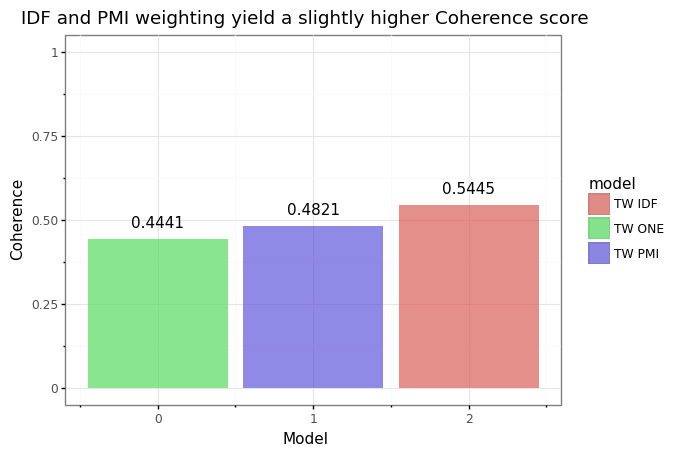

<ggplot: (8766964721993)>

In [ ]:
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE", "TW PMI", "TW IDF"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

(ggplot(df_coherence) +
 geom_bar(aes(x='index', y="value", fill="model"), 
          stat="identity", alpha=0.7) +
 geom_text(aes(x="index",y=df_coherence.value.values +0.05, label="value")) +
 theme_bw() +
 lims(y=(0,1)) +
 labs(y="Coherence", x="Model", title="IDF and PMI weighting yield a slightly higher Coherence score") 
)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/sentisum/sentisum-assessment-dataset.csv')
#df = df.dropna(subset=['Text'])
print(df.head())

                                                text
0  Tires where delivered to the garage of my choi...
1  Easy Tyre Selection Process, Competitive Prici...
2         Very easy to use and good value for money.
3              Really easy and convenient to arrange
4  It was so easy to select tyre sizes and arrang...


In [ ]:
from scripts.newsgrp_preprocess import run_preprocess

news_df, word_list_lemmatized = run_preprocess_e(df)

Tokenizing...

Removing Stopwords...

Create bigrams...

Lemmatizing, keeping NOUN,VERB,ADV,ADJ POS tags...

Done preprocessing 10132 documents


In [ ]:

def topic_importance(model, news_df, txt):
    ''''''
    out_df = pd.DataFrame()
    
    for i, row in enumerate(txt):
        doc_inst = model.make_doc(row)
        topic_dist, ll = model.infer(doc_inst, together=True)
        topic_idx = np.array(topic_dist).argmax()
  
        words = dict(model.get_topic_words(topic_idx)).keys()
        k_words = ", ".join(list(words))
        out_df = out_df.append(pd.Series([int(topic_idx), k_words]), ignore_index=True)
    
    original_docs = pd.Series(news_df.text.values)
    true_labels = pd.Series(news_df.topic_name.values)
    out_df = pd.concat([out_df, true_labels, original_docs], axis=1)
    
    
    return out_df